## Comparando y evaluando algoritmos clustering

Uno de los desafíos en la aplicación de algoritmos de clustering es que es muy difícil evaluar qué tan bien funciona un algoritmo y como  comparar resultados entre diferentes algoritmos.

Existen métricas que se pueden usar para evaluar el resultado de un algoritmo de agrupamiento relativo a clustering los más importantes `adjusted randindex`(ARI) y `normalized mutual information`(NMI), que proporcionan una medida cuantitativa entre 0 y 1.

In [1]:
%matplotlib inline
import numpy as np

from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])

Comparamos la asignación aleatoria, k-mean,clustering aglomerativo y DBSCAN en el conjunto de datos `two_moons` utilizando el puntaje ARI supervisado.

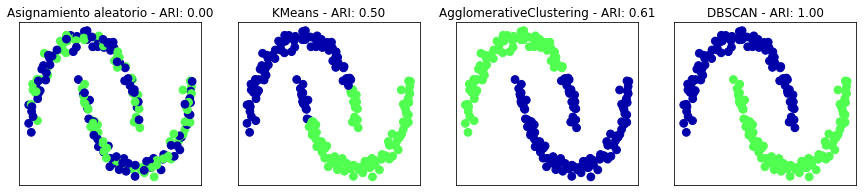

In [2]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Rescalamos los datos, media 0 y varianza 1 
escalador = StandardScaler()
escalador.fit(X)
X_escalado = escalador.transform(X)

fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# hacemos una lista de algoritmos a usar 
algoritmos = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

# creamos una asignacion de cluster aleatoria por referencia
estado_aleatorio = np.random.RandomState(seed=0)
clusters_aleatorio = estado_aleatorio.randint(low=0, high=2, size=len(X))

# dibujamos la asignacion aleatoria
axes[0].scatter(X_escalado[:, 0], X_escalado[:, 1], c=clusters_aleatorio, cmap=cm3, s=60)
axes[0].set_title("Asignamiento aleatorio - ARI: {:.2f}".format( adjusted_rand_score(y,clusters_aleatorio)))

for ax, algoritmo in zip(axes[1:], algoritmos):
    # dibuja los asignamiento de clusters y centros de clusters 
    clusters = algoritmo.fit_predict(X_escalado)
    ax.scatter(X_escalado[:, 0], X_escalado[:, 1], c=clusters, cmap=cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algoritmo.__class__.__name__,
                                           adjusted_rand_score(y, clusters)))

ARI, proporciona resultados intuitivos, con una asignación aleatoria de clusters que tiene una puntuación de 0 y DBSCAN (que recupera perfectamente la agrupación deseada) con una puntuación de 1.

Un error común cuando se evalúa el clustering de esta manera es utilizar `accuracy_score` en lugar de `adjusted_rand_score`, `normalized_mutual_info_score` o alguna otra métrica de clúster. El problema al usar la precisión es que requiere que las etiquetas del clúster asignadas coincidan exactamente con los datos observados . Sin embargo, las etiquetas de los clústeres no tienen sentido; lo único que importa es qué puntos están en el mismo clúster.


In [3]:
from sklearn.metrics import accuracy_score
# estos dos  puntos etiquetados corresponden al mismo clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# la precisión es cero, ya que ninguna de las etiquetas es la misma
print("Precision: {:.2f}".format(accuracy_score(clusters1, clusters2)))
# adjusted rand es 1, ya que el clustering es exactamente la misma
print("ARI: {:.2f}".format(adjusted_rand_score(clusters1, clusters2)))

Precision: 0.00
ARI: 1.00


Existen métricas de puntuación para el clustering que no requieren datos observados, como `silhouette coefficient`. Sin embargo, estos a menudo no funcionan bien en la práctica. El puntuación de estos coeficientes calcula la compacidad de un clúster, donde a más alto es mejor, con una puntuación perfecta de 1. Mientras que los clústeres compactos son buenos, la compacidad no permite formas complejas.

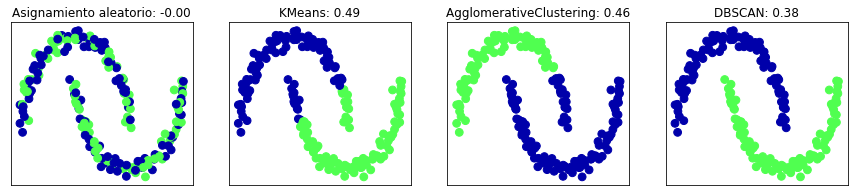

In [4]:
from sklearn.metrics.cluster import silhouette_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)

# Rescalamos los datos, media 0 y varianza 1 
escalador = StandardScaler()
escalador.fit(X)
X_escalado = escalador.transform(X)
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
                         subplot_kw={'xticks': (), 'yticks': ()})

# creamos una asignacion de cluster aleatoria por referencia
estado_aleatorio = np.random.RandomState(seed=0)
clusters_aleatorio = estado_aleatorio.randint(low=0, high=2, size=len(X))

# dibujamos la asignacion aleatoria
axes[0].scatter(X_escalado[:, 0], X_escalado[:, 1], c=clusters_aleatorio, cmap=cm3, s=60)
axes[0].set_title("Asignamiento aleatorio: {:.2f}".format( silhouette_score(X_escalado,clusters_aleatorio)))

# hacemos una lista de algoritmos a usar 
algoritmos = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2), DBSCAN()]

for ax, algoritmo in zip(axes[1:], algoritmos):
    # dibuja los asignamiento de clusters y centros de clusters 
    clusters = algoritmo.fit_predict(X_escalado)
    ax.scatter(X_escalado[:, 0], X_escalado[:, 1], c=clusters, cmap=cm3, s=60)
    ax.set_title("{}: {:.2f}".format(algoritmo.__class__.__name__,
                                           silhouette_score(X_escalado, clusters)))


Como se puede ver, k-means obtiene el puntaje de silhouette más alto, aunque podríamos preferir el resultado producido por DBSCAN. Una estrategia ligeramente mejor para evaluar clusters es usar métricas de clustering basadas en robustez. Estos ejecutan un algoritmo después de agregar algo de ruido a los datos, o usar diferentes configuraciones de parámetros  y comparar los resultados. La idea es que si muchos parámetros de algoritmo y muchas perturbaciones de los datos devuelven el mismo resultado, es probable que sean confiables. Pero esto no esta implementado en scikit-learn.

### Comparando algoritmos en el conjunto de datos Labeled faces

Vamos a aplicar los algoritmos k-means, DBSCAN y aglomeración de clústeres a `Labeled faces` en el conjunto de datos Wild  y ver si alguno de ellos encuentra una estructura interesante. Usaremos la representación eigenface de los datos, como fue producida por `PCA (whiten = True)`, con 100 componentes:

In [5]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
%matplotlib inline

personas= fetch_lfw_people(min_faces_per_person=20, resize=0.7)
imagen_shape = personas.images[0].shape

mascara = np.zeros(personas.target.shape, dtype=np.bool)
for objetivo in np.unique(personas.target):
    mascara[np.where(personas.target == objetivo)[0][:50]] = 1

X_personas = personas.data[mascara]
y_personas = personas.target[mascara]
X_personas = X_personas / 255.

In [6]:
# extraemos eigenfaces desde los  lfw y tranformamos la data
from sklearn.decomposition import PCA
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_personas)
X_pca = pca.transform(X_personas)

#### Analizandos los datos lfw con DBSCAN 

In [7]:
dbscan = DBSCAN()
etiquetas = dbscan.fit_predict(X_pca)
print("Etiquetas unicas: {}".format(np.unique(etiquetas)))

Etiquetas unicas: [-1]


Vemos que todas las etiquetas devueltas son -1, por lo que todos los datos fueron etiquetados como "ruido" por DBSCAN. Hay dos cosas que podemos cambiar para ayudar a esto: podemos hacer que los eps sean más altos, para expandir el vecindario de cada punto, y establecer `min_samples` más bajo, para considerar grupos más pequeños de puntos como clusters. Probemos primero cambiando `min_samples`:

In [8]:
dbscan = DBSCAN(min_samples=3)
etiquetas = dbscan.fit_predict(X_pca)
print("Etiquetas unicas: {}".format(np.unique(etiquetas)))

Etiquetas unicas: [-1]


Incluso cuando se consideran grupos de tres puntos, todo se etiqueta como ruido. Entonces, necesitamos aumentar el eps:

In [9]:
dbscan = DBSCAN(min_samples=3, eps=15)
etiquetas = dbscan.fit_predict(X_pca)
print("Etiquetas unicas: {}".format(np.unique(etiquetas)))

Etiquetas unicas: [-1  0]


Si usamos un número mucho mayor de 15, obtenemos solo un solo grupo y puntos de ruido. Podemos usar este resultado para descubrir cómo se ve el "ruido" en comparación con el resto de los datos. Para comprender mejor lo que está sucediendo, veamos cuántos puntos son el ruido y cuántos puntos hay dentro del clúster:

In [10]:
print("Numero de puntos  por  cluster: {}".format(np.bincount(etiquetas + 1)))

Numero de puntos  por  cluster: [  28 1549]


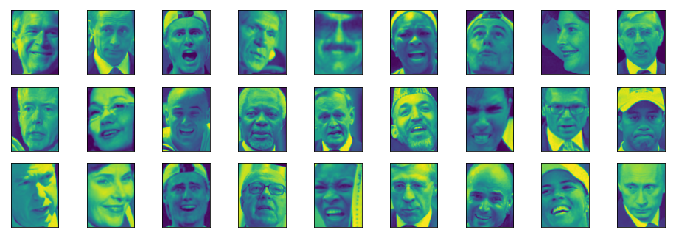

In [11]:
ruido = X_personas[etiquetas==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
figsize=(12, 4))
for imagen, ax in zip(ruido, axes.ravel()):
    ax.imshow(imagen.reshape(imagen_shape), vmin=0, vmax=1)

Comparando estas imágenes con la muestra aleatoria de imágenes faciales del conjunto de datos, podemos adivinar por qué fueron etiquetadas como ruido: hay imágenes de personas usando sombreros, imágenes contienen ángulos extraños demasiado cercanos o demasiado anchos.

Este tipo de análisis, tratando de encontrar "la excepción", se llama detección atípica. Si se tratara de una aplicación real, podríamos intentar hacer un mejor trabajo recortando imágenes para obtener datos más homogéneos. Es poco lo que podemos hacer acerca de las personas en las fotos, a veces usando sombreros, bebiendo o sosteniendo algo delante de sus caras, pero es bueno saber que estos son problemas en los datos que cualquier algoritmo que apliquemos debe manejar.

Si queremos encontrar clusters más interesantes que solo uno grande, necesitamos establecer eps más pequeños, en algún lugar entre 15 y 0.5 (por defecto). Echemos un vistazo a los diferentes valores de los eps en:


In [12]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    etiquetas= dbscan.fit_predict(X_pca)
    print("Clusters presentes: {}".format(np.unique(etiquetas)))
    print("Tamaño de los clusters: {}".format(np.bincount(etiquetas + 1)))


eps=1
Clusters presentes: [-1]
Tamaño de los clusters: [1577]

eps=3
Clusters presentes: [-1]
Tamaño de los clusters: [1577]

eps=5
Clusters presentes: [-1]
Tamaño de los clusters: [1577]

eps=7
Clusters presentes: [-1  0  1  2  3  4  5  6  7]
Tamaño de los clusters: [1527   15    3    3    5   14    3    3    4]

eps=9
Clusters presentes: [-1  0  1  2]
Tamaño de los clusters: [974 597   3   3]

eps=11
Clusters presentes: [-1  0]
Tamaño de los clusters: [ 335 1242]

eps=13
Clusters presentes: [-1  0]
Tamaño de los clusters: [  95 1482]


Para ajustes bajos de eps, todos los puntos están etiquetados como ruido. Para eps = 7, obtenemos muchos puntos de ruido y muchos clústeres más pequeños. Para eps = 9 todavía obtenemos muchos puntos de ruido, pero obtenemos un gran clúster y algunos clústeres más pequeños. A partir de eps = 11, obtenemos solo un gran clúster y ruido.

Lo que es interesante observar es que nunca hay más de un gran grupo. Como máximo, hay un clúster grande que contiene la mayoría de los puntos y algunos clústeres más pequeños. Esto indica que no hay dos o tres tipos diferentes de imágenes faciales en los datos que son muy distintas, sino más bien que todas las imágenes son más o menos igualmente similares (o disímiles) al resto.

Los resultados para eps = 7 parecen muy interesantes, con muchos clusters pequeños. Podemos investigar este agrupamiento con más detalle visualizando todos los puntos en cada uno de los 13 pequeños grupos.

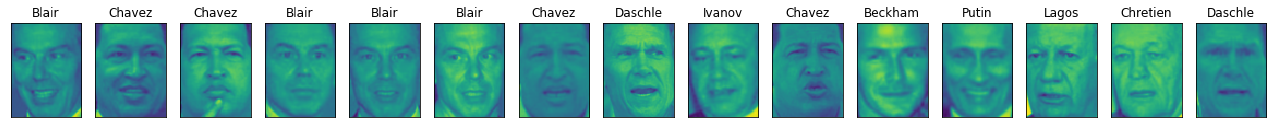

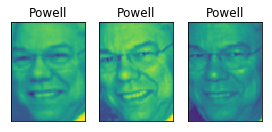

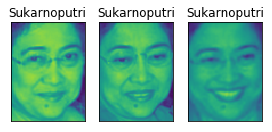

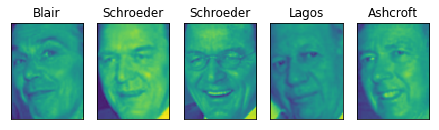

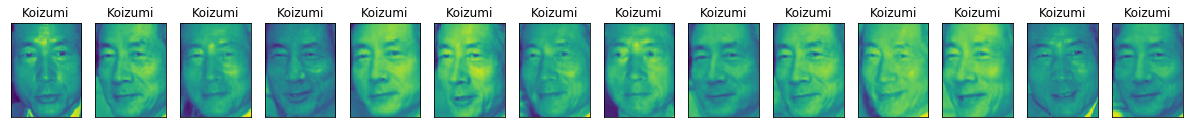

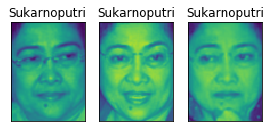

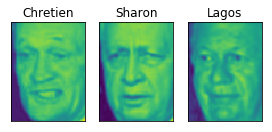

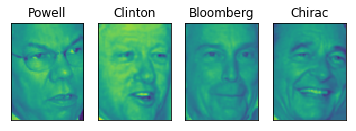

In [13]:
dbscan = DBSCAN(min_samples=3, eps=7)
etiquetas = dbscan.fit_predict(X_pca)
for cluster in range(max(etiquetas) + 1):
    mascara = etiquetas == cluster
    n_imagenes = np.sum(mascara)
    fig, axes = plt.subplots(1, n_imagenes, figsize=(n_imagenes * 1.5, 4),
    subplot_kw={'xticks': (), 'yticks': ()})
    for imagen, etiqueta, ax in zip(X_personas[mascara], y_personas[mascara], axes):
        ax.imshow(imagen.reshape(imagen_shape), vmin=0, vmax=1)
        ax.set_title(personas.target_names[etiqueta].split()[-1])

#### Analizandos los datos lfw con k-means

Vimos que no era posible crear más de un gran clúster utilizando DBSCAN. El cluster  aglomerativo y k-means son mucho más propensos a crear clusters de tamaño par, pero tenemos que establecer un número objetivo de clusters. 

Podríamos establecer el número de clústeres para la cantidad conocida de personas en el conjunto de datos, aunque es muy poco probable que un algoritmo de clúster no supervisado los recupere. En cambio, podemos comenzar con un bajo número de clusters, como 10, lo que podría permitirnos analizar cada uno de los clusters:

In [24]:
# Extraemos clusters con k-means
km = KMeans(n_clusters=10, random_state=0)
etiquetas_km = km.fit_predict(X_pca)
print("Tamaño de clusteres con k-means: {}".format(np.bincount(etiquetas_km)))

Tamaño de clusteres con k-means: [229  73 142 162 117 109 284 229 123 109]


Como se puede ver, k-means particionó los datos en clústeres de tamaño relativamente similar de 64 a 386. Esto es bastante diferente del resultado de DBSCAN.

Podemos analizar más a fondo el resultado de k-means visualizando los centros de cluster. A medida que nos agrupamos en la representación producida por PCA, necesitamos rotar los centros del clúster nuevamente en el espacio original para visualizarlos, usando `pca.inverse_transform`:

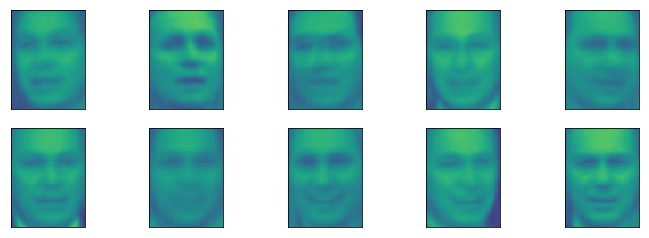

In [25]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()}, figsize=(12, 4))
for centro, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(centro).reshape(imagen_shape),vmin=0, vmax=1)

Los centros de clúster encontrados por k-means son versiones de caras muy suaves. Esto no es muy sorprendente, dado que cada centro tiene un promedio de 64 a 386 imágenes faciales. Trabajar con una representación de PCA reducida se suma a la suavidad de las imágenes. El clustering parece captar diferentes orientaciones del rostro, diferentes expresiones dentro del grupo.

In [26]:
def dibuja_rostros_kmeans(km, pca, X_pca, X_personas, y_personas, nombre_objetivos):
    n_clusters = 10
    imagen_shape = (87, 65)
    fig, axes = plt.subplots(n_clusters, 11, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(10, 15), gridspec_kw={"hspace": .3})

    for cluster in range(n_clusters):
        centro = km.cluster_centers_[cluster]
        mascara = km.labels_ == cluster
        distancias = np.sum((X_pca - centro) ** 2, axis=1)
        distancias[~mascara] = np.inf
        inds = np.argsort(distancias)[:5]
        distancias[~mascara] = -np.inf
        inds = np.r_[inds, np.argsort(distancias)[-5:]]
        axes[cluster, 0].imshow(pca.inverse_transform(centro).reshape(imagen_shape), vmin=0, vmax=1)
        for imagen, etiqueta, asdf, ax in zip(X_personas[inds], y_personas[inds],
                                          km.labels_[inds], axes[cluster, 1:]):
            ax.imshow(imagen.reshape(imagen_shape), vmin=0, vmax=1)
            ax.set_title("%s" % (nombre_objetivos[etiqueta].split()[-1]), fontdict={'fontsize': 9})

    # agregue algunos cuadros para ilustrar cuales imagenes  son similares y cuales disímiles
    rec = plt.Rectangle([-5, -30], 73, 1295, fill=False, lw=2)
    rec = axes[0, 0].add_patch(rec)
    rec.set_clip_on(False)
    axes[0, 0].text(0, -40, "Centro")

    rec = plt.Rectangle([-5, -30], 385, 1295, fill=False, lw=2)
    rec = axes[0, 1].add_patch(rec)
    rec.set_clip_on(False)
    axes[0, 1].text(0, -40, "Cercano al centro")

    rec = plt.Rectangle([-5, -30], 385, 1295, fill=False, lw=2)
    rec = axes[0, 6].add_patch(rec)
    rec.set_clip_on(False)
    axes[0, 6].text(0, -40, "Lejos del centro")

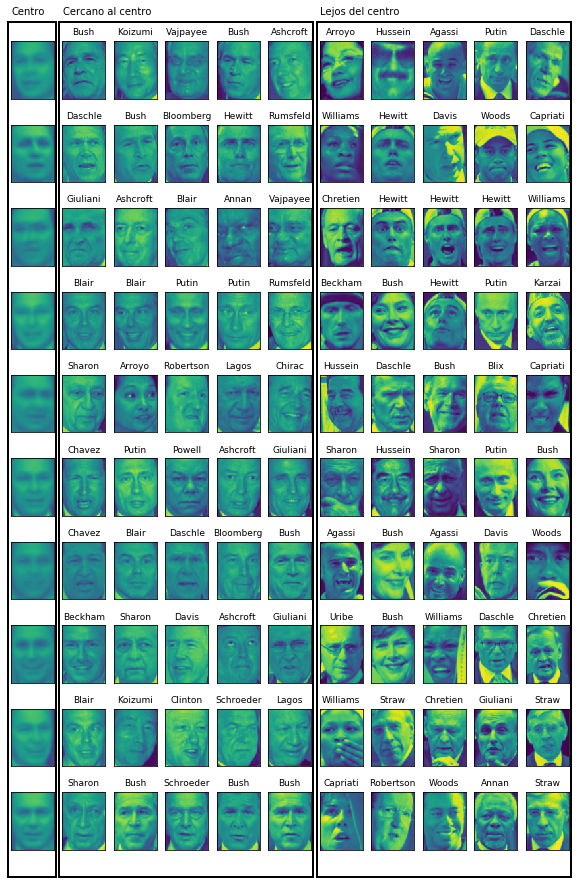

In [27]:
dibuja_rostros_kmeans(km, pca, X_pca, X_personas, y_personas, personas.target_names)

La figura anterior confirma nuestra intuición sobre caras sonrientes para el tercer clúster y también la importancia de la orientación para los otros grupos. Sin embargo, los puntos "atípicos" no son muy similares a los centros de clusters, y su asignación parece un tanto arbitraria. Esto se puede atribuir al hecho de que k-means divide todos los puntos de datos y no tiene un concepto de puntos de "ruido", como lo hace DBSCAN.

Usando una mayor cantidad de clusters, el algoritmo podría encontrar distinciones más finas. Sin embargo, agregar más clusters  hace que la inspección manual sea aún más difícil.


#### Analizandos los datos lfw con clusters aglomerativos

Para este caso extraemos clusters utilizamos  clustering aglomerativo ward.

In [28]:
aglomerativo = AgglomerativeClustering(n_clusters=10)
etiquetas_aglomerativo = aglomerativo.fit_predict(X_pca)
print("Tamaño de cluster en clustering aglomerativo: {}".format(np.bincount(etiquetas_aglomerativo)))

Tamaño de cluster en clustering aglomerativo: [243 623  64  44 158 160  34  37 172  42]


Clustering aglomerativo también produce clusters  de tamaño relativamente igual, con clusters de tamaños  entre 26 y 623. Estos son más desiguales que los producidos por k-means, pero mucho más incluso que los producidos por DBSCAN.

Podemos calcular el ARI para medir si las dos particiones de los datos proporcionados por el clustering aglomerativo y k-means son similares:

In [30]:
print("ARI: {:.2f}".format(adjusted_rand_score(etiquetas_aglomerativo, etiquetas_km)))

ARI: 0.07


Este resultado no es muy sorprendente, dado el hecho de que los puntos más alejados de los centros del clusters parecen tener poco en común para los k-means.

Limitaremos la profundidad del árbol en el gráfico, ya que la bifurcación hacia los 2.063 puntos de datos individuales daría lugar a un gráfico densamente indescifrable:

Text(0,0.5,'Distancia de clusters')

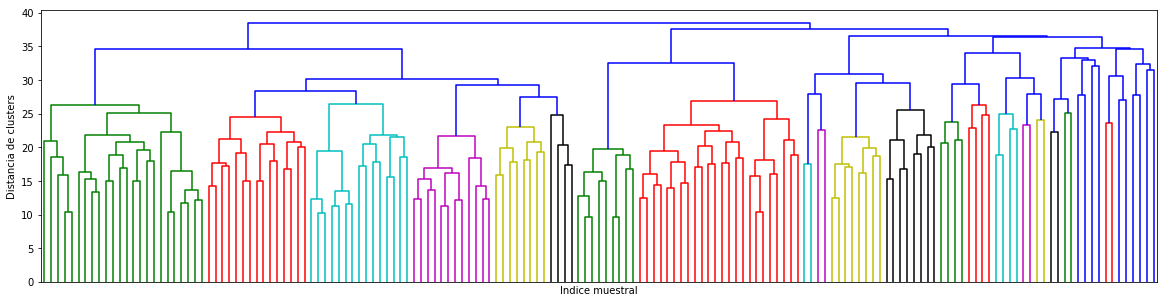

In [32]:
from scipy.cluster.hierarchy import dendrogram, ward

matriz_enlaces= ward(X_pca)
plt.figure(figsize=(20, 5))
dendrogram(matriz_enlaces, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Indice muestral")
plt.ylabel("Distancia de clusters")

Creando 10 clusters, cortamos el árbol en la parte superior, donde hay 10 líneas verticales. En el dendrograma para los datos anterior  que se muestran anteriormente, se puede ver que por la longitud de las ramas, que dos o tres clusters pueden capturar los datos de manera apropiada.

Para los datos de rostros, no parece haber un punto de corte muy natural. Hay algunas ramas que representan clusters más distintos, pero no parece haber un número particular de clústeres que se ajuste bien. Esto no es sorprendente, dados los resultados de DBSCAN, que intentó agrupar todos los puntos.

Visualicemos los 10 clusters, como se realizó  para k-means. Hay que tener en cuenta que no existe una noción de centro de clúster en clustering aglomerativa (aunque podríamos calcular la media) y  mostrar  los primeros puntos en cada cluster. Mostramos el número de puntos en cada cluster a la izquierda de la primera imagen:

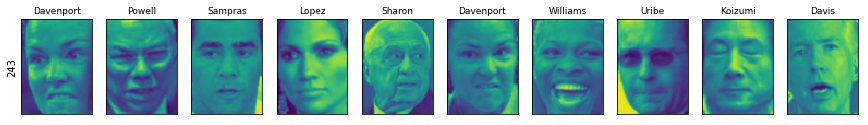

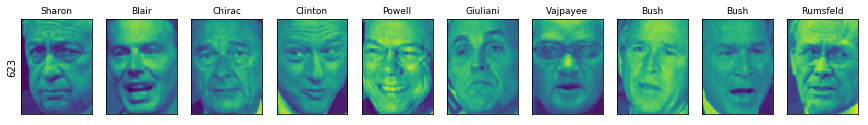

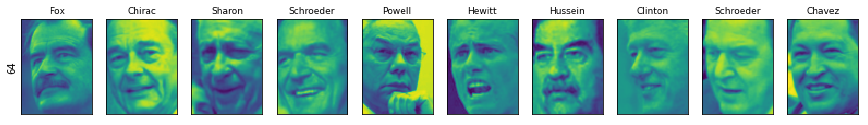

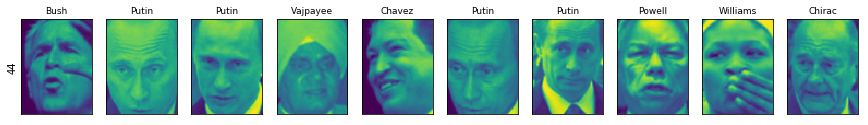

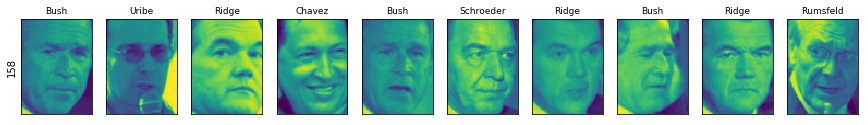

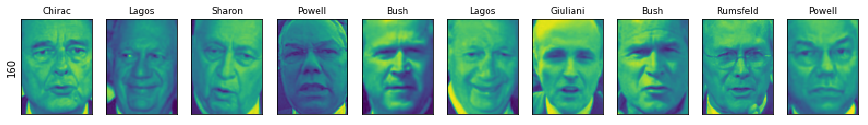

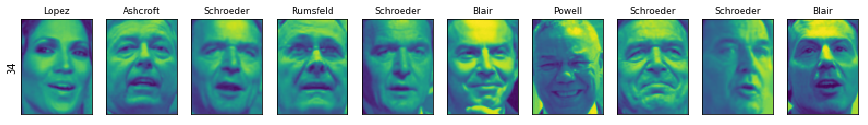

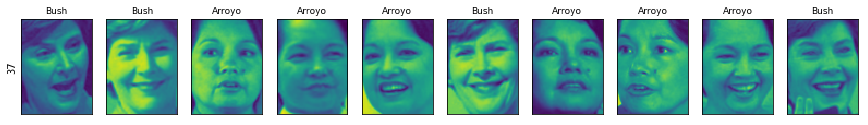

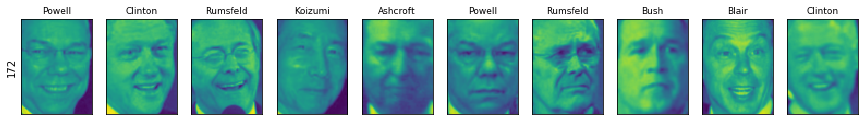

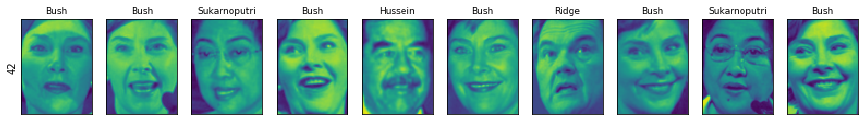

In [34]:
# Imágenes aleatorias de los clusters generados  de tamaño [243 623  64  44 158 160  34  37 172  42].
# el número a la izquierda enumera el número de imágenes en cada cluster

n_clusteres = 10
for cluster in range(n_clusteres):
    mascara = etiquetas_aglomerativo == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mascara))
    for imagen,etiqueta, asdf, ax in zip(X_personas[mascara], y_personas[mascara],etiquetas_aglomerativo[mascara], axes):
        ax.imshow(imagen.reshape(imagen_shape), vmin=0, vmax=1)
        ax.set_title(personas.target_names[etiqueta].split()[-1],fontdict={'fontsize': 9})

Si bien algunos de los clusters parecen tener un tema semántico, muchos de ellos son demasiado grandes para ser realmente homogéneos. Para obtener clusters más homogéneos, podemos ejecutar el algoritmo de nuevo, esta vez con 40 clusters y seleccionar algunos de los clusters que son particularmente interesantes:

Tamaño de cluster en clustering aglomerativo: [ 58  55  40  71  96  83  34   9  24  38 101  20   3 182  42  83   9  30
  74  31  16   6  21   9  20  76   5  97   2  55  15   2   2  28  16  19
  33  25   1  46]


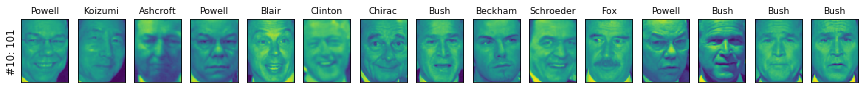

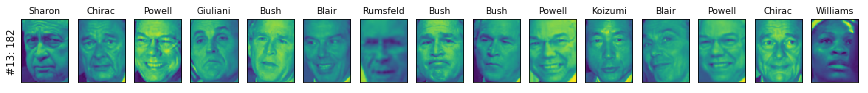

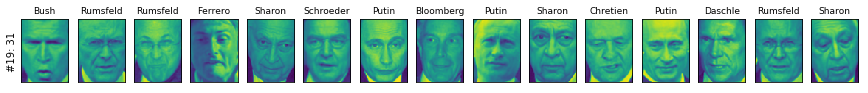

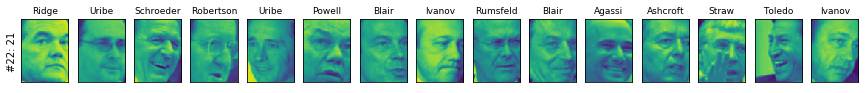

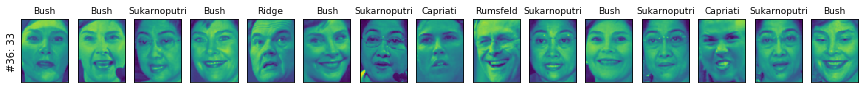

In [35]:
aglomerativo = AgglomerativeClustering(n_clusters=40)
etiquetas_aglomerativo = aglomerativo.fit_predict(X_pca)
print("Tamaño de cluster en clustering aglomerativo: {}".format(np.bincount(etiquetas_aglomerativo)))

n_clusteres = 40
for cluster in [10, 13, 19, 22, 36]:
    mascara = etiquetas_aglomerativo == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()},
                             figsize=(15, 8))
    tam_cluster = np.sum(mascara)
    axes[0].set_ylabel("#{}: {}".format(cluster, tam_cluster))
    for imagen, etiqueta, asdf, ax in zip(X_personas[mascara], y_personas[mascara],
                                      etiquetas_aglomerativo[mascara], axes):
        ax.imshow(imagen.reshape(imagen_shape), vmin=0, vmax=1)
        ax.set_title(personas.target_names[etiqueta].split()[-1], fontdict={'fontsize': 9})
    for i in range(tam_cluster, 15):
        axes[i].set_visible(False)

Aquí, el clustering parece haber mejorado en diversos aspectos. También podríamos encontrar estos clusters muy similares usando un dendrograma, si se realiza un análisis más detallado.
